Import necessary packages and set up defauls for figure formatting:

In [1]:
import glob #filenames and pathnames utility
import os   #operating sytem utility

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.signal import savgol_filter

import pickle

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

%matplotlib inline

%autosave 0

# set global default style:
sns.set_style("white")
sns.set_style("ticks", {'xtick.direction':'in', 'xtick.top':True, 'ytick.direction':'in', 'ytick.right':True, })
#sns.set_style({"axes.labelsize": 20, "xtick.labelsize" : 16, "ytick.labelsize" : 16})

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.edgecolor'] = 'k'

box_size = 8

Autosave disabled


In [2]:
main_dir = os.getcwd()
main_dir

'C:\\Users\\djross\\Documents\\Python Scripts\\culture_reproducibility'

In [3]:
os.chdir(main_dir)
glob.glob('*.pkl')

['all_OD_frames_2.pkl', 'all_sample_frames.pkl']

Import data (plate layouts and plate reader data, formatted as Pandas dataframes):

In [4]:
all_sample_frames = pickle.load(open('all_sample_frames.pkl', 'rb'))
all_OD_frames_2 = pickle.load(open('all_OD_frames_2.pkl', 'rb'))

Use Savitsky-Golay filter to find the maximum slope and maximum slope time for each growth curve:

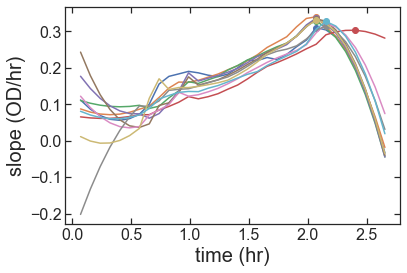

In [5]:
show_plot = True
max_plots = 10
num_plots = 0
if show_plot:
    plt.rcParams["figure.figsize"] = [6, 4]
    fig, axs = plt.subplots()

for sample_frame, OD_plate_2 in zip(all_sample_frames, all_OD_frames_2):
    max_slope_list = []
    max_slope_pos_list = []

    x = np.array(OD_plate_2['Time (h)'])
    slope_time = x
    delta_time = x[1] - x[0]

    for well in sample_frame['well']:
        y = np.array(OD_plate_2[well])
        slope = savgol_filter(y, 13, 3, deriv=1)/delta_time

        max_slope = max(slope[slope_time>1.5])
        max_slope_pos = slope_time[ np.where(slope==max_slope)[0][0] ]

        max_slope_list.append(max_slope)
        max_slope_pos_list.append(max_slope_pos)
        if show_plot:
            if num_plots < max_plots:
                plot_ret = axs.plot(slope_time, slope)
                axs.plot([max_slope_pos], [max_slope], 'o', color=plot_ret[0].get_color())
                num_plots += 1

    sample_frame['max_slope'] = max_slope_list
    sample_frame['max_slope_time'] = max_slope_pos_list

if show_plot:
    axs.set_ylabel('slope (OD/hr)')
    axs.set_xlabel('time (hr)')

Define and apply the well position categories:

In [6]:
def well_category_funct(w):
    if (w=='A1') or (w=='A12') or (w=='H1') or (w=='H12'):
        return 'corner'
    elif (w=='D6') or (w=='D7') or (w=='E6') or (w=='E7'):
        return 'center'
    elif (w[0]=='A') or (w[0]=='H') or (w[1:]=='1') or (w[1:]=='12'):
        return 'edge1'
    elif (w[0]=='B') or (w[0]=='G') or (w[1:]=='2') or (w[1:]=='11'):
        return 'edge2'
    elif (w[0]=='C') or (w[0]=='F') or (w[1:]=='3') or (w[1:]=='10'):
        return 'edge3'
    else:
        return 'near_center'

In [7]:
for df in all_sample_frames:
    df['well_category'] = [ well_category_funct(x) for x in df.well ]

Prepare the output data to be used for the linear mixed effect models (Data analysis and figures.2.ipynb):

In [8]:
out_frame = pd.concat(all_sample_frames, ignore_index=True)
out_frame.rename(columns={"inducerConcentration": "IPTG"}, inplace=True)

In [9]:
out_columns = ['plate_id', 'well', 'well_category', 'IPTG', 'max_slope', 'max_slope_time', 
               'plate_1_0', 'plate_1_f', 'user']

In [10]:
os.chdir(main_dir)
out_frame[out_columns].to_csv('all_growth_plate_data.csv')

In [11]:
len(all_sample_frames), len(out_frame)

(150, 10896)

Figure 2 is a plot of all the growht curves from a single experiment:

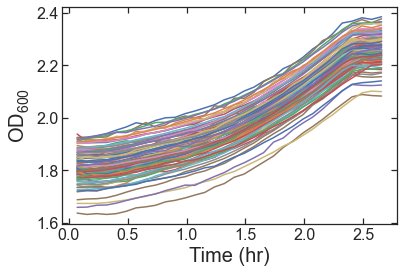

In [12]:
plt.rcParams["figure.figsize"] = [6, 4]
fig, axs = plt.subplots()
    
df = all_OD_frames_2[3]
x = df['Time (h)']
all_wells = np.unique(all_sample_frames[3].well)

for w in all_wells:
    y = df[w]
    axs.plot(x, y);
axs.set_xlabel('Time (hr)')
axs.set_ylabel('OD$\mathregular{_{600}}$');

fig.savefig("Fig. 2.png", bbox_inches="tight")